In [43]:
dict_args = {
  "MODEL_TYPE": "LogisticRegressionOnSimCLR",
  "model_name": "logistic_regression01",

  "encoder_path": "../checkpoints/simclr01.ckpt",

  "DATA_PATH": "../data/",
  "data_split": [3, 1],
  "CHECKPOINT_PATH": "../checkpoints",
  "first_patient": 1,
  "num_patients_train": 5,
  "num_patients_test": 5,
  "batch_size": 64,

  "num_workers": 8,
  "lr": 1e-3,
  "weight_decay": 1e-3,
  "max_epochs": 30
}
from argparse import Namespace
args = Namespace(**dict_args)

In [7]:
import os

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from tqdm.notebook import tqdm

import constants
from datasets.SHHS_dataset_timeonly import SHHS_dataset_1, EEGdataModule

from models.logistic_regression import LogisticRegression
from models.simclr_model import CNNmodel_SimCLR
import torch
import torch.utils.data as data
from copy import deepcopy
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.load_and_save_model import load_model


In [3]:
@torch.no_grad()
def prepare_data_features(model, data_loader, device):
    # Prepare model
    network = deepcopy(model.f)
    network.g = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_inputs, batch_labels in tqdm(data_loader):
        batch_inputs = batch_inputs.to(device)
        batch_feats = network(batch_inputs.squeeze(dim=1))
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    return data.TensorDataset(feats, labels)

In [10]:

device = torch.device('cpu')
model = load_model(CNNmodel_SimCLR, args.encoder_path)  # Load pretrained simclr model
dm = EEGdataModule(**dict_args)  # Load datamodule
dm.setup()

In [11]:
train_ds = prepare_data_features(model, dm.train_dataloader(), device)
val_ds = prepare_data_features(model, dm.val_dataloader(), device)
test_ds = prepare_data_features(model, dm.test_dataloader(), device)

C:\Users\tomsm\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:563: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

(array([1.1574e+04, 2.1240e+03, 1.9870e+03, 1.6480e+03, 1.3950e+03,
        1.1060e+03, 8.6500e+02, 6.5600e+02, 5.1300e+02, 4.0600e+02,
        2.9800e+02, 2.6600e+02, 2.1800e+02, 1.5600e+02, 1.2500e+02,
        1.1900e+02, 9.1000e+01, 8.7000e+01, 7.8000e+01, 5.7000e+01,
        3.9000e+01, 3.6000e+01, 2.4000e+01, 2.5000e+01, 1.9000e+01,
        1.8000e+01, 1.4000e+01, 1.1000e+01, 1.0000e+01, 8.0000e+00,
        3.0000e+00, 7.0000e+00, 2.0000e+00, 6.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.13488989, 0.26977977, 0.40466964, 0.53955954,
        0.6744494 , 0.8093393 , 0.9442291 , 1.0791191 , 1.2140089 ,
        1.3488988 , 1.4837887 , 1.6186786 , 1.7535684 , 1.8884583 ,
        2.023348  , 2.1582382 , 2.293128  , 2.4280179 , 2.5629077 ,
        2.6977975 , 2.8326874 , 2.9675775 , 3.

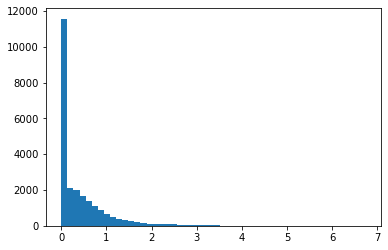

In [29]:
import matplotlib.pyplot as plt
import numpy as np
feature = train_ds.__getitem__(0)[0]
plt.hist(np.asarray(feature), bins=50)

In [35]:
sum(feature < 0.51)/feature.size(0)

tensor(0.7085)

In [37]:
trainer = pl.Trainer(default_root_dir=os.path.join(args.CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=args.max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False,
                         check_val_every_n_epoch=10)
trainer.logger._default_hp_metric = None

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
train_loader = data.DataLoader(train_ds, batch_size=args.batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=args.num_workers)
val_loader = data.DataLoader(val_ds, batch_size=args.batch_size, shuffle=True,
                                 drop_last=False, pin_memory=True, num_workers=args.num_workers)
test_loader = data.DataLoader(test_ds, batch_size=args.batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=args.num_workers)

In [40]:
log_model = LogisticRegression(feature_dim=int(constants.SLEEP_EPOCH_SIZE/8*model.hparams.model_hparams['conv_filters'][-1]), **dict_args)

In [45]:
trainer.fit(log_model, train_loader, val_loader)

Missing logger folder: checkpoints\LogisticRegression\lightning_logs

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 120 K 
---------------------------------
120 K     Trainable params
0         Non-trainable params
120 K     Total params
0.480     Total estimated model params size (MB)
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=30` reached.


In [47]:
print(trainer.checkpoint_callback.best_model_path)

checkpoints\LogisticRegression\lightning_logs\version_0\checkpoints\epoch=29-step=1680.ckpt
